# Neural network for predicting the use of charging stations

This notebook describes the development and analysis of a neural network for predicting the hourly utilization of charging stations.

In [49]:
import os
os.chdir(r'C:\Users\chrii\PycharmProjects\AAEnergizer')
print(os.getcwd())  # Verify the new working directory

C:\Users\chrii\PycharmProjects\AAEnergizer


## Data Preparation for Neural Networks

In **Notebook 1**, we have already covered the basics of the data preparation. This notebook focuses on two key aspects that are crucial for the final dataset creation for the neural network:


1. **Adding holiday, season, and weekend information**
2. **Creating an hourly dataset for time series analysis**

---

#### **1. Holidays, Seasons, and Weekends**
The `add_holidays` method extends the dataset with the following columns:
- **`is_holiday`**: Marks holidays based on the US Federal Holiday Calendar.
- **`is_weekend`**: Identifies Saturdays and Sundays.
- **`is_vacation`**: Marks typical vacation dates (parts of June, July, August, and December e.g.).
- **`season`**: Assigns the appropriate season (Spring, Summer, Fall, or Winter) to each row.

To ensure accurate prediction of future values, these indicators are shifted by 24 hours. This accounts for the temporal dependency in predictions. Additionally, seasons and hours of the day are transformed into sine and cosine values to make cyclical patterns machine-readable.

---

#### **2. Creating the Time Series Dataset**
The `create_nn_ds` method generates a dataset that captures the hourly utilization of charging stations (`activeSessions`) for different sites. Weather data (temperature and precipitation), as well as holidays, weekends, and seasons, are also integrated.

**Steps in Brief:**
1. **Hourly Data Aggregation**:
   All connections are aggregated into hourly intervals based on the start and end times of the sessions.
2. **Integration of Weather Data**:
   Temperature and precipitation are interpolated on an hourly basis and merged with the aggregated data.
3. **Data Cleaning**:
   - The final dataset is cut from 2018-04-25 to 2020-03-01.
       - Data points outside the relevant time period (e.g., starting from the COVID-19 period due to unreliable information) are removed.
      - Data from sites that lacked complete information for specific time periods are also excluded.

---
This section has been added solely for explanation purposes, as the corresponding code was already executed in Notebook 1.


In [40]:
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
import numpy as np

def add_holidays(df):
    df['hour'] = pd.to_datetime(df['hour'])
    df['date'] = df['hour'].dt.date

    cal = USFederalHolidayCalendar()
    holidays = cal.holidays(start=df['hour'].min(), end=df['hour'].max()).to_pydatetime()
    holiday_dates = set([d.date() for d in holidays])

    df['is_holiday'] = df['date'].apply(lambda x: 1 if x in holiday_dates else 0)
    df['is_weekend'] = df['hour'].dt.weekday.apply(lambda x: 1 if x >= 5 else 0)
    df['is_vacation'] = df['hour'].dt.month.apply(lambda x: 1 if x in [6, 7, 8, 12] else 0)

    # verschiebe die zeilen holiday weekend und vac 24 stunden nach oben, da wir zukünftige werte vorhersagen wollen
    df['is_holiday'] = df['is_holiday'].shift(-24)
    df['is_weekend'] = df['is_weekend'].shift(-24)
    df['is_vacation'] = df['is_vacation'].shift(-24)


    def season(month):
        if month in [12, 1, 2]:
            return 'Winter'
        elif month in [3, 4, 5]:
            return 'Spring'
        elif month in [6, 7, 8]:
            return 'Summer'
        else:
            return 'Fall'

    df['season'] = df['hour'].dt.month.apply(season)
    df.drop(columns=['date'], inplace=True)

    return df

def create_nn_ds(dataset_path, weather_dataset_path, nn_dataset_path):
    df = pd.read_csv(dataset_path)
    weather_df = pd.read_csv(weather_dataset_path)

    df['connectionTime'] = pd.to_datetime(df['connectionTime'])
    df['disconnectTime'] = pd.to_datetime(df['disconnectTime'])
    weather_df['timestamp'] = pd.to_datetime(weather_df['timestamp']) - pd.Timedelta(hours=8)
    weather_df['hourly_timestamp'] = weather_df['timestamp'].dt.floor('h')

    weather_df = weather_df.groupby('hourly_timestamp').agg({
        'temperature': 'mean',
        'precipitation': 'mean'
    }).interpolate(method='linear').reset_index()

    # Berechne alle Stunden im Zeitintervall
    time_intervals = pd.date_range(
        start=df['connectionTime'].min().floor('h'),
        end=df['disconnectTime'].max().ceil('h'),
        freq='h'
    )

    site_ids = df['siteID'].unique()
    hourly_data = []

    print("Berechnung stündlicher aktiver Sessions und Ladeleistung...")
    i=0
    for start_time in time_intervals:
        i += 1
        if i % 500 == 0:
            print(f"Processed {i}/{len(time_intervals)} hours...")
        end_time = start_time + pd.Timedelta(hours=1)
        row = {'hour': start_time}

        for site_id in site_ids:
            # Filter für aktive Sessions
            site_df = df[df['siteID'] == site_id]
            active_sessions = site_df[
                (site_df['connectionTime'] < end_time) & (site_df['disconnectTime'] > start_time)
                ]

            avg_power = active_sessions['chargingPower'].mean() if not active_sessions.empty else 0
            active_session_count = len(active_sessions)

            row[f'avgChargingPower_site_{site_id}'] = avg_power
            row[f'activeSessions_site_{site_id}'] = active_session_count

        hourly_data.append(row)

    hourly_df = pd.DataFrame(hourly_data)
    hourly_df['hour'] = hourly_df['hour'].dt.tz_localize(None)
    weather_df['hourly_timestamp'] = weather_df['hourly_timestamp'].dt.tz_localize(None)

    # Merging Wetterdaten
    hourly_df = pd.merge(hourly_df, weather_df, left_on='hour', right_on='hourly_timestamp', how='left')
    hourly_df.drop(columns=['hourly_timestamp'], inplace=True)

    # jetzt ist jede uhrzeit 2 mal da und es ist immer entweder die eine oder die andere siteID gefüllt, die andere ist null

    # Feiertage hinzufügen (falls implementiert)
    hourly_df = add_holidays(hourly_df)

    # Speichern der Ergebnisse
    hourly_df.to_csv(nn_dataset_path, index=False)

    return hourly_df


In [ ]:
import pandas as pd
import numpy as np


def add_sin_cos_time_features(df):
    # Spalte 'hour' in datetime umwandeln
    df['hour'] = pd.to_datetime(df['hour'])

    # Stunde extrahieren
    df['hour_of_day'] = df['hour'].dt.hour

    # Sinus- und Kosinus-Transformation für die Stunden (tageszyklisch)
    df['hour_sin'] = np.sin(2 * np.pi * df['hour_of_day'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour_of_day'] / 24)

    return df


def add_sin_cos_season_features(df):
    # Mapping der Jahreszeiten auf numerische Werte
    season_mapping = {'Spring': 0, 'Summer': 1, 'Fall': 2, 'Winter': 3}
    df['season_num'] = df['season'].map(season_mapping)

    # Sinus- und Kosinus-Transformation für die Jahreszeiten (zyklisch)
    df['season_sin'] = np.sin(2 * np.pi * df['season_num'] / 4)
    df['season_cos'] = np.cos(2 * np.pi * df['season_num'] / 4)

    return df

# Ergänzte Funktion zur Interpolation von Wetterdaten
def interpolate_weather_data(weather_df):
    # Sicherstellen, dass die 'hour'-Spalte als datetime interpretiert wird
    weather_df['hour'] = pd.to_datetime(weather_df['hour'])

    # Sortiere den DataFrame nach Zeitstempel
    weather_df = weather_df.sort_values(by='hour')

    # Lineare Interpolation für die Spalten 'temperature' und 'precipitation'
    weather_df[['temperature', 'precipitation']] = weather_df[['temperature', 'precipitation']].interpolate(
        method='linear', limit_direction='both'
    )

    return weather_df



def prepare_nn_ds(dataset_path):
    # Load the dataset
    df = pd.read_csv(dataset_path)

    # Add sine and cosine transformations for time and season
    df = add_sin_cos_time_features(df)
    df = add_sin_cos_season_features(df)

    # Interpolate weather data
    df = interpolate_weather_data(df)


    # sort the columns Index(['hour', 'avgChargingPower', 'activeSessions', 'temperature',
    #        'precipitation', 'is_holiday', 'is_weekend', 'is_vacation', 'season',
    #        'hour_of_day', 'hour_sin', 'hour_cos', 'season_num', 'season_sin',
    #        'season_cos'],
    #       dtype='object')
    df = df[['hour', 'temperature', 'precipitation', 'is_holiday', 'is_weekend',
             'is_vacation', 'season', 'hour_of_day', 'hour_sin', 'hour_cos',
             'season_num', 'season_sin', 'season_cos', 'avgChargingPower_site_1',
             'activeSessions_site_1', 'avgChargingPower_site_2', 'activeSessions_site_2']]

    # add the column 'day_of_week' to the dataframe, so monday is 0 and sunday is 6
    df['day_of_week'] = df['hour'].dt.dayofweek

    # Save the updated DataFrame back to CSV
    df.to_csv(dataset_path, index=False)

    print("Dataset preparation completed.")

if __name__ == "__main__":
    prepare_nn_ds(dataset_path="data/processed/hourly_avg_power.csv")

In [42]:
import pandas as pd

def cut_ds(dataset_path, start_date, end_date):
    # Lade den Datensatz
    dataset = pd.read_csv(dataset_path)

    # Stelle sicher, dass die 'hour'-Spalte als Datetime erkannt wird
    dataset['hour'] = pd.to_datetime(dataset['hour'])

    # Filtere den Datensatz basierend auf Start- und Enddatum
    filtered_dataset = dataset[(dataset['hour'] >= start_date) & (dataset['hour'] <= end_date)]

    # save the filtered dataset as a new csv file with same name but ending with _cut
    filtered_dataset.to_csv(dataset_path.replace('.csv', '_cut.csv'), index=False)

    return filtered_dataset

if __name__ == "__main__":
    cut_ds("data/processed/hourly_avg_power.csv", "2018-09-05", "2020-03-01")

## Correlation analysis
After creating the dataset, a correlation analysis was performed to evaluate the influence of various factors, such as weather conditions and temperature, on the number of active sessions. This analysis provided the following key insights:


- **Weak correlations**: Most variables, such as "temperature" and "precipitation," exhibit weak or negligible correlations with other inputs, suggesting limited linear relationships.

- **Moderate correlations**: Stronger relationships are observed between:
  - "activeSessions_site_1" and "activeSessions_site_2" (0.68), indicating shared activity patterns.
  - "is_weekend" and "day_of_week" (0.48), reflecting logical calendar relationships.

- **Impact on our neural networks**: Including weakly correlated factors like "temperature" or "precipitation" in a neural network likely provides minimal predictive benefit. Prior tests confirmed no improvement in model performance when these variables were included.## Correlation analysis
This correlation matrix reveals several insights about the relationships between variables:

- **Weak correlations**: Most variables, such as "temperature" and "precipitation," exhibit weak or negligible correlations with other inputs, suggesting limited linear relationships.

- **Moderate correlations**: Stronger relationships are observed between:
  - "activeSessions_site_1" and "activeSessions_site_2" (0.68), indicating shared activity patterns.
  - "is_weekend" and "day_of_week" (0.48), reflecting logical calendar relationships.

- **Impact on our neural networks**: Including weakly correlated factors like "temperature" or "precipitation" in a neural network likely provides minimal predictive benefit. Prior tests confirmed no improvement in model performance when these variables were included.

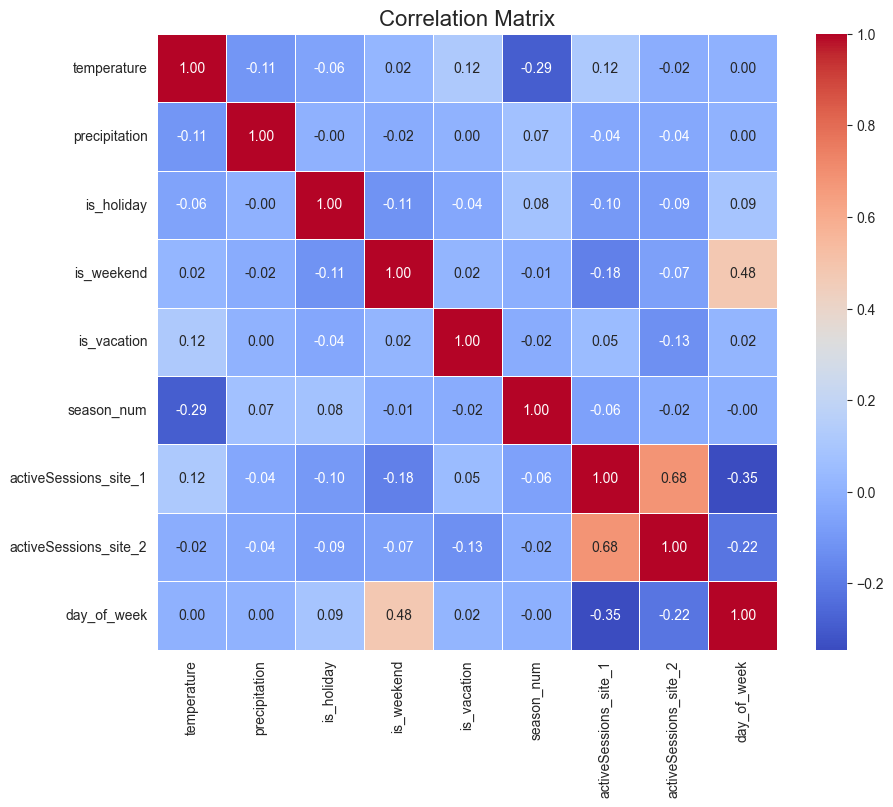

In [50]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def calculate_and_plot_correlation(file_path):
    """
    Berechnet eine bereinigte Korrelationsmatrix aus den relevanten Spalten eines Datensatzes
    und visualisiert sie in einem farblich abgestimmten Heatmap-Plot.

    :param file_path: Pfad zur CSV-Datei.
    """
    # Daten einlesen
    data = pd.read_csv(file_path)

    # Relevante Spalten (ohne abgeleitete oder redundante Werte wie avgChargingPower)
    columns_to_include = [
        'temperature',
        'precipitation',
        'is_holiday',
        'is_weekend',
        'is_vacation',
        'season_num',
        'activeSessions_site_1',
        'activeSessions_site_2',
        'day_of_week'
    ]

    # Nur die ausgewählten Spalten verwenden
    filtered_data = data[columns_to_include]

    # Korrelationsmatrix berechnen
    correlation_matrix = filtered_data.corr()

    # Heatmap plotten
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Correlation Matrix", fontsize=16)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10, rotation=0)
    plt.show()

# Beispielverwendung
file_path = "data/processed/hourly_avg_power_cut.csv"
calculate_and_plot_correlation(file_path)

## Data preparation

The data is loaded from a CSV file and divided into training, validation and test data sets. The relevant input and target variables are:

- **Input variables:** `['hour_sin', 'hour_cos', 'is_holiday', 'is_weekend', 'is_vacation']`
- **Target variables:** `['activeSessions_site_1', 'activeSessions_site_2']`

In [51]:
import torch
import torch.nn as nn
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import DataLoader, Dataset
import pytorch_lightning as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Dataset-Klasse ---
class PowerDataset(Dataset):
    def __init__(self, data, input_columns, target_columns, sequence_length, forecast_horizon):
        self.features = data[input_columns].values
        self.targets = data[target_columns].values
        self.sequence_length = sequence_length
        self.forecast_horizon = forecast_horizon

    def __len__(self):
        return len(self.features) - self.sequence_length - self.forecast_horizon + 1

    def __getitem__(self, idx):
        x = self.features[idx: idx + self.sequence_length]
        y = self.targets[idx + self.sequence_length: idx + self.sequence_length + self.forecast_horizon]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# --- Daten laden ---
df = pd.read_csv("data/processed/hourly_avg_power_cut.csv")
train_size = int(len(df) * 0.7)
val_size = int(len(df) * 0.2)
test_size = len(df) - train_size - val_size

train_df = df.iloc[:train_size].copy()
val_df = df.iloc[train_size:train_size + val_size].copy()
test_df = df.iloc[train_size + val_size:].copy()

input_columns = ['hour_sin', 'hour_cos', 'is_holiday', 'is_weekend', 'is_vacation']
target_columns = ['activeSessions_site_1', 'activeSessions_site_2']

sequence_length = 24
forecast_horizon = 24

train_dataset = PowerDataset(train_df, input_columns, target_columns, sequence_length, forecast_horizon)
val_dataset = PowerDataset(val_df, input_columns, target_columns, sequence_length, forecast_horizon)
test_dataset = PowerDataset(test_df, input_columns, target_columns, sequence_length, forecast_horizon)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Model architecture

The neural network is based on an LSTM model that is particularly suitable for sequential data. The architecture includes:

- **LSTM layer:** Extracts temporal features from the input sequences.
- **Fully Connected Layer:** Projection onto the target variables.

In [52]:
class UtilizationPredictor(pl.LightningModule):
    def __init__(self, input_size, hidden_size, num_layers, output_size, forecast_horizon, learning_rate):
        super(UtilizationPredictor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size * forecast_horizon)
        self.criterion = nn.MSELoss()
        self.dropout = nn.Dropout(0.3)
        self.learning_rate = learning_rate
        self.forecast_horizon = forecast_horizon

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out.view(-1, self.forecast_horizon, int(out.shape[1]/self.forecast_horizon))

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

## Training

The model is trained with a training data set and monitors the validation errors during training. A ModelCheckpoint saves the best model based on the validation loss.

The hyperparameters are the follwing:
- **Input size:** Number of input features.
- **Hidden size:** Number of hidden units in the LSTM layer.
- **Number of layers:** Number of LSTM layers.
- **Output size:** Number of output features.
- **Forecast horizon:** Number of time steps to predict into the future.
- **Learning rate:** Learning rate for the optimizer.
- **Max epochs:** Maximum number of epochs for training.


In [53]:
if __name__ == '__main__':
    model = UtilizationPredictor(
        input_size=len(input_columns),
        hidden_size=128,
        num_layers=3,
        output_size=len(target_columns),
        forecast_horizon=forecast_horizon,
        learning_rate=0.001
    )

    checkpoint_callback = ModelCheckpoint(
        monitor="val_loss",
        dirpath="models",
        filename="utilization-predictor-{epoch:02d}-{val_loss:.4f}",
        save_top_k=1,
        mode="min"
    )

    trainer = pl.Trainer(
        max_epochs=300,
        log_every_n_steps=1,
        callbacks=[checkpoint_callback]
    )

    trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\chrii\PycharmProjects\AAEnergizer\.venv311\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: UserWarning:

Checkpoint directory C:\Users\chrii\PycharmProjects\AAEnergizer\models exists and is not empty.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | lstm      | LSTM    | 333 K  | train
1 | fc        | Linear  | 6.2 K  | train
2 | criterion | MSELoss | 0      | train
3 | dropout   | Dropout | 0      | train
----------------------------------------------
339 K     Trainable params
0         Non-trainable params
339 K     Total params
1.358     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\chrii\PycharmProjects\AAEnergizer\.venv311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: PossibleUserWarning:

The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

C:\Users\chrii\PycharmProjects\AAEnergizer\.venv311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: PossibleUserWarning:

The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.



Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


# Grid Search
Grid search was used to evaluate various combinations of hyperparameters, such as:

- Hidden size: 64, 128, 256
- Number of layers: 2, 4, 6
- Batch size: 32, 64
- Learning rate: 0.0001, 0.001, 0.01

This approach ensured a thorough exploration of different configurations.

In [ ]:
# --- 4. Training starten ---
if __name__ == '__main__':
    from sklearn.model_selection import ParameterGrid
    import torch
    import pytorch_lightning as pl
    from pytorch_lightning.callbacks import ModelCheckpoint
    from pytorch_lightning.loggers import MLFlowLogger
    import mlflow

    # --- 5. Grid Search Setup ---
    param_grid = {
        'hidden_size': [64, 128, 256],
        'num_layers': [2, 4, 6],
        'batch_size': [32, 64],
        'learning_rate': [0.0001, 0.001, 0.01]
    }

    grid = ParameterGrid(param_grid)

    # --- 6. Grid Search Loop ---
    for params in grid:
        hidden_size = params['hidden_size']
        num_layers = params['num_layers']
        batch_size = params['batch_size']
        learning_rate = params['learning_rate']

        # Update DataLoader with current batch size
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        # Define the model
        model = UtilizationPredictor(
            input_size=len(input_columns),
            hidden_size=hidden_size,
            num_layers=num_layers,
            output_size=len(target_columns),
            forecast_horizon=forecast_horizon,
            learning_rate=learning_rate
        )

        # Set up ModelCheckpoint and Logger
        checkpoint_callback = ModelCheckpoint(
            monitor="val_loss",
            dirpath="models",
            filename=f"model_{hidden_size}_{num_layers}_{batch_size}_{learning_rate:.4f}-{{epoch:02d}}-{{val_loss:.5f}}",
            save_top_k=1,
            mode="min",
        )

        mlf_logger = MLFlowLogger(
            experiment_name="Power Utilization Prediction - Grid Search",
            save_dir="./mlruns"  # Local directory for logs
        )
        mlflow.pytorch.autolog()

        # Trainer initialization
        trainer = pl.Trainer(
            max_epochs=200,  # 200 epochs as specified
            log_every_n_steps=1,
            callbacks=[checkpoint_callback],
            logger=mlf_logger,  # Attach MLflow logger
        )

        # Training
        trainer.fit(model, train_loader, val_loader)

        # Testing
        trainer.test(model, test_loader)

        # End MLflow run
        mlflow.end_run()

The outputs were parsed into an array for better visualization (lstm_param_results.csv). It was found that the combination of 128 hidden size, 2 layers, 0.001 learning rate, and a validation loss of 26.56 yielded the best result, and therefore, this configuration was used for the predictions:

In [61]:
import pandas as pd
import plotly.graph_objects as go
import colorsys
import matplotlib.colors as mcolors

def lighten_color(hex_color, increase=0.1):
    """
    Increases the brightness of a color by the specified percentage.

    :param hex_color: Hex code of the color (e.g. '#f03b3e')
    :param increase: Increase factor (e.g. 0.1 for 10%)
    :return: Hex code of the brightened color
    """
    rgb = mcolors.to_rgb(hex_color)
    h, l, s = colorsys.rgb_to_hls(*rgb)
    l = min(1, l + increase * l)
    r, g, b = colorsys.hls_to_rgb(h, l, s)
    return mcolors.to_hex((r, g, b))

original_red = '#23c93f'
original_green = '#ee1111'

light_red = lighten_color(original_red, 0.1)
light_green = lighten_color(original_green, 0.1)

colorscale = [
    [0.0, light_red],
    [1.0, light_green]
]

file_path = "src/models/lstm_param_results.csv"
try:
    df = pd.read_csv(file_path)
    if 'Val Loss' not in df.columns:
        raise ValueError("The column 'Val Loss' is missing in the CSV file.")
except Exception as e:
    print(f"Error loading the CSV file: {e}")
    df = None

if df is not None:
    desired_lrs = [0.0001, 0.001, 0.01]
    df = df[df['learning_rate'].isin(desired_lrs)]

    df['learning_rate'] = df['learning_rate'].astype(str)

    df['hidden_num_layers'] = df.apply(lambda row: f"HS:{row['hidden_size']} NL:{row['num_layers']}", axis=1)

    pivot_df = df.pivot_table(index='hidden_num_layers',
                              columns='learning_rate',
                              values='Val Loss')

    desired_lrs_str = ['0.0001', '0.001', '0.01']
    pivot_df = pivot_df.reindex(columns=desired_lrs_str)

    zmin = 25
    zmax = 37

    fig = go.Figure(data=go.Heatmap(
        z=pivot_df.values,
        x=pivot_df.columns,
        y=pivot_df.index,
        colorscale=colorscale,
        zmin=zmin,
        zmax=zmax,
        colorbar=dict(title='Val Loss'),
        text=pivot_df.values,
        texttemplate="%{text:.2f}",
        textfont={"size": 12, "color": "black"},
        hovertemplate='Val Loss: %{z}<br>Learning Rate: %{x}<br>Hidden/Layer: %{y}<extra></extra>',
        xgap=2,
        ygap=2
    ))

    fig.update_layout(
        title='Heatmap of the validation loss via parameter combinations',
        xaxis_title='Learning Rate',
        yaxis_title='Hidden Size / Num Layers',
        xaxis=dict(tickmode='array', tickvals=list(range(len(desired_lrs_str))), ticktext=desired_lrs_str),
        yaxis=dict(tickmode='array', tickvals=list(range(len(pivot_df.index))), ticktext=pivot_df.index),
        template='plotly_white',
        width=800,
        height=600
    )

    fig.show()

## Analysis and visualization

After training, the model is evaluated on the test data and the predictions are compared with the actual values. The following graphic shows the results for the "Active Sessions" at Site 1 and 2:

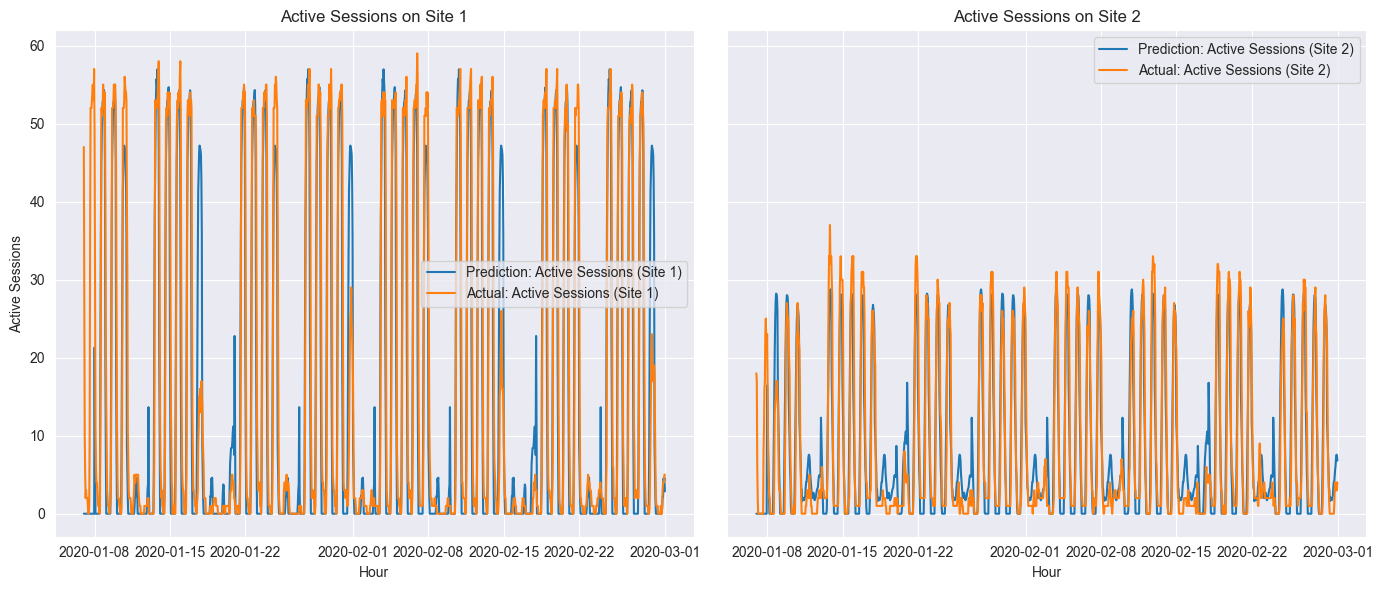

In [62]:
import torch
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import joblib
from src.models.lstm_24h_v2 import UtilizationPredictor

def prepare_24h_batches(df, start_hour=0):
    """
    Divides the dataset into 24-hour sections, starting at `start_hour`.
    """
    df['hour_of_day'] = df['hour'].dt.hour
    start_indices = df[df['hour_of_day'] == start_hour].index

    batches = []
    for start_idx in start_indices:
        if start_idx + 24 <= len(df):
            batch = df.iloc[start_idx:start_idx + 24]
            batches.append(batch)

    return batches

def generate_plots_for_24h_predictions(
        ckpt_path: str,
        test_batches,
        target_columns,
        input_columns,
        device: str = "cpu"
):
    """
    Makes predictions for 24h batches and creates a common diagram.
    """
    model = UtilizationPredictor.load_from_checkpoint(ckpt_path)
    model.to(device)
    model.eval()

    all_predictions = []
    all_actuals = []
    all_hours = []

    with torch.no_grad():
        for batch in test_batches:
            input_data = batch[input_columns].values
            targets = batch[target_columns].values
            hours = batch["hour"].values

            input_tensor = torch.tensor(input_data, dtype=torch.float32).unsqueeze(0).to(device)
            target_tensor = torch.tensor(targets, dtype=torch.float32).unsqueeze(0).to(device)

            predictions = model(input_tensor).cpu().numpy()

            all_predictions.append(predictions[0])  # Batch (24, num_targets)
            all_actuals.append(targets)  # (24, num_targets)
            all_hours.append(hours)  # (24,)

    # Create DataFrames
    all_predictions = np.concatenate(all_predictions, axis=0)
    all_actuals = np.concatenate(all_actuals, axis=0)
    all_hours = np.concatenate(all_hours, axis=0)

    # 24h shift
    shifted_predictions = np.zeros_like(all_predictions)
    shifted_predictions[24:] = all_predictions[:-24]

    col_pred = [f"pred_{col}" for col in target_columns]
    col_act = [f"actual_{col}" for col in target_columns]

    df_predictions = pd.DataFrame(shifted_predictions, columns=col_pred)
    df_actuals = pd.DataFrame(all_actuals, columns=col_act)
    df_combined = pd.concat([df_predictions, df_actuals], axis=1)
    df_combined['hour'] = all_hours

    plot_active_sessions_sites(df_combined)

    # Create plotly diagram
    fig = go.Figure()
    target_columns = [
        'activeSessions_site_1',
        'activeSessions_site_2'
    ]
    for col in target_columns:
        fig.add_trace(go.Scatter(
            x=df_combined["hour"],
            y=df_combined[f"pred_{col}"],
            mode="lines",
            name=f"Prediction: {col}"
        ))
        fig.add_trace(go.Scatter(
            x=df_combined["hour"],
            y=df_combined[f"actual_{col}"],
            mode="lines",
            name=f"Actual: {col}"
        ))

    fig.update_layout(
        title="24h Predictions vs. Actuals (Interactive)",
        xaxis_title="Hour",
        yaxis_title="Value",
        legend_title="Legend - Click to Toggle"
    )
    fig.show()

    # Save the plot
    fig.write_html("output/24h_predictions.html")

def plot_active_sessions_sites(df_combined):
    # Extract data for site 1
    hours = df_combined["hour"]
    pred_active_sessions_site_1 = df_combined["pred_activeSessions_site_1"]
    actual_active_sessions_site_1 = df_combined["actual_activeSessions_site_1"]

    # Extract data for site 2
    pred_active_sessions_site_2 = df_combined["pred_activeSessions_site_2"]
    actual_active_sessions_site_2 = df_combined["actual_activeSessions_site_2"]

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

    # Plot for Site 1
    axes[0].plot(hours, pred_active_sessions_site_1, label="Prediction: Active Sessions (Site 1)", linestyle='-')
    axes[0].plot(hours, actual_active_sessions_site_1, label="Actual: Active Sessions (Site 1)", linestyle='-')
    axes[0].set_title("Active Sessions on Site 1")
    axes[0].set_xlabel("Hour")
    axes[0].set_ylabel("Active Sessions")
    axes[0].legend()
    axes[0].grid(True)

    # Plot for Site 2
    axes[1].plot(hours, pred_active_sessions_site_2, label="Prediction: Active Sessions (Site 2)", linestyle='-')
    axes[1].plot(hours, actual_active_sessions_site_2, label="Actual: Active Sessions (Site 2)", linestyle='-')
    axes[1].set_title("Active Sessions on Site 2")
    axes[1].set_xlabel("Hour")
    axes[1].legend()
    axes[1].grid(True)

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()

if __name__ == "__main__":
    # --- Parameter ---
    target_columns = [
        'avgChargingPower_site_1',
        'activeSessions_site_1',
        'avgChargingPower_site_2',
        'activeSessions_site_2'
    ]

    input_columns = ['hour_sin', 'hour_cos', 'is_holiday', 'is_weekend', 'is_vacation']

    dummies = ['day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6']
    input_columns += dummies
    sequence_length = 24

    # Load test dates
    df_test = pd.read_csv("data/processed/test_dataset_shifted.csv", parse_dates=["hour"])


    scaler_features = joblib.load('models/scaler_features.pkl')
    scaler_targets = joblib.load('models/scaler_targets.pkl')
    df_test[input_columns] = df_test[input_columns].astype('float32')
    df_test[target_columns] = df_test[target_columns].astype('float32')

    # Prepare 24h batches
    test_batches = prepare_24h_batches(df_test, start_hour=0)

    ckpt_path = "models/model_128_2_32_0.0010-epoch=77-val_loss=26.56100.ckpt"

    # Generate predictions and plots
    generate_plots_for_24h_predictions(
        ckpt_path=ckpt_path,
        test_batches=test_batches,
        target_columns=target_columns,
        input_columns=input_columns,
        device="cpu"
    )


# Some Metrics
The two charts display the training and validation loss over multiple epochs.

### Left Chart: "Train and Validation Loss (All Epochs)"
- This shows the full training process over 300 epochs.
- After epoch 100, both training and validation loss stabilize, indicating the model is mostly trained.

### Right Chart: "Train and Validation Loss (Up to Epoch 100 for Deepdive)"
- Focused on the first 100 epochs for a closer look.
- Significant improvements occur up to around epoch 80–100, after which both losses plateau.
- No signs of overfitting as validation loss remains stable.

### Conclusion
The model reaches optimal performance around epoch 100, so **early stopping** was applied at epoch 168 to prevent overfitting.







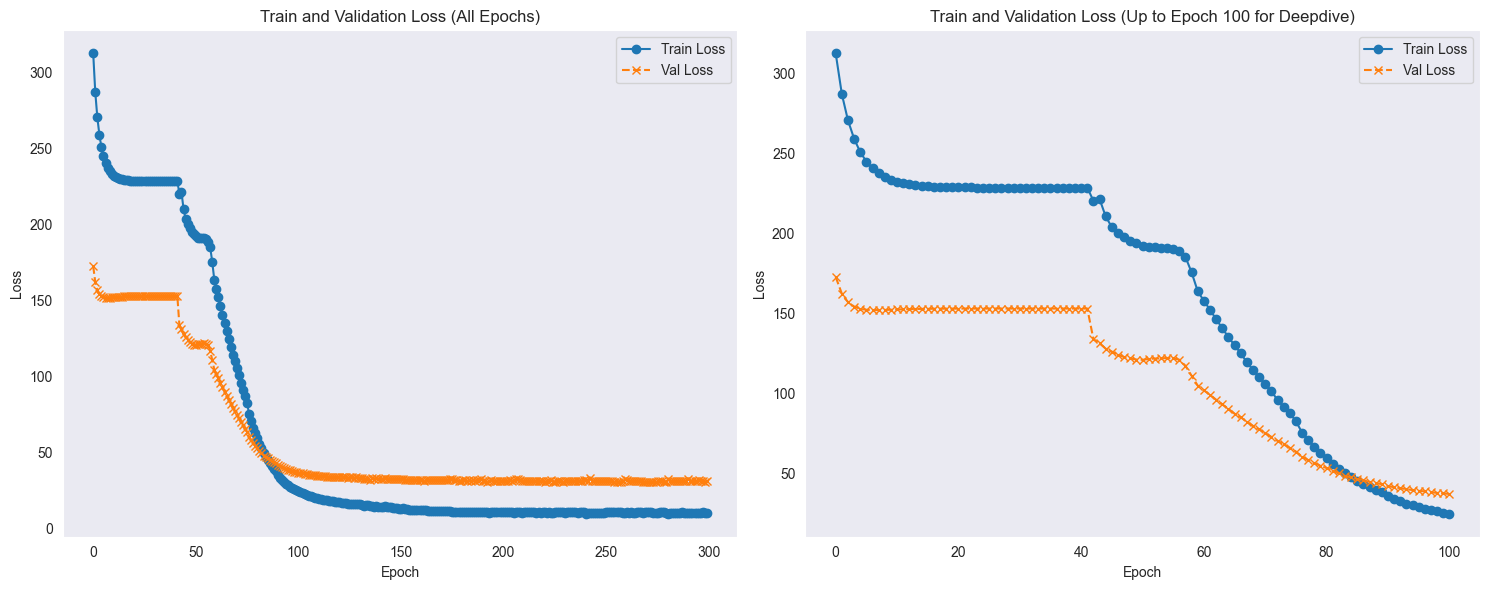

In [63]:
import mlflow
import pandas as pd
import matplotlib.pyplot as plt

# Set the tracking URI
mlflow.set_tracking_uri("file:///C:/Users/chrii/PycharmProjects/AAEnergizer/mlruns")

# Run-ID definieren
run_id = "4980ed976643473f8b039fd264f8825f"

# MLflow-Client erstellen
client = mlflow.tracking.MlflowClient()

# Metriken aus dem Run abrufen
metrics = ["train_loss", "val_loss"]
history = {metric: client.get_metric_history(run_id, metric) for metric in metrics}

# Daten in ein DataFrame umwandeln
df = pd.DataFrame({
    "Step": [metric.step for metric in history["train_loss"]],
    "Train Loss": [metric.value for metric in history["train_loss"]],
    "Val Loss": [metric.value for metric in history["val_loss"]]
})

# Plotten der gesamten Daten und der ersten 150 Epochen nebeneinander
plt.figure(figsize=(15, 6))

# Gesamte Daten plotten
plt.subplot(1, 2, 1)
plt.plot(df["Step"], df["Train Loss"], label="Train Loss", linestyle='-', marker='o')
plt.plot(df["Step"], df["Val Loss"], label="Val Loss", linestyle='--', marker='x')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and Validation Loss (All Epochs)")
plt.legend()
plt.grid()

# Daten bis Epoche 150 plotten
df_limited = df[df["Step"] <= 100]
plt.subplot(1, 2, 2)
plt.plot(df_limited["Step"], df_limited["Train Loss"], label="Train Loss", linestyle='-', marker='o')
plt.plot(df_limited["Step"], df_limited["Val Loss"], label="Val Loss", linestyle='--', marker='x')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and Validation Loss (Up to Epoch 100 for Deepdive)")
plt.legend()
plt.grid()

# Anzeigen
plt.tight_layout()
plt.show()
